In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
eps_start = 1
eps_end = 0.01
eps_decay = 0.9983 #125e-6
train_episodes = 2500
test_episodes = 1
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Choose the environment
em = EnvManager(device, 'combrf-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=8, bias=True)
)


## Test with random untrained actions

In [5]:
obs = em.env.reset()
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 6.11010277e-09  3.29491542e-08  4.31309047e-08 -2.81945424e-08
   1.01850273e-08  8.93463694e-09 -2.70804423e-08  4.22745297e-08
  -5.28607717e-08  5.76852877e-08  3.86517752e-08 -5.05895488e-08
   5.70131554e-08 -5.72224338e-08  5.11945731e-08 -3.95865988e-08
   2.36637587e-08 -5.16161281e-09]]
6
Episode score: 0.36787944117144233


## Train the DQN agent

c:\pycharm_workspace\precoding_rl\venv\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


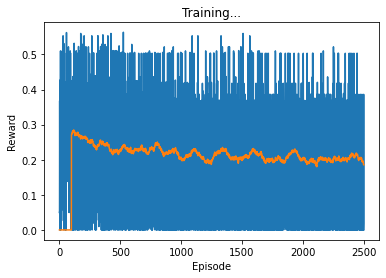

In [6]:
ep_rewards = []
policy_net.train()

outer = tqdm.tqdm_notebook(total=train_episodes, desc='training loop: ', position=0)

for episode in range(train_episodes):
    obs = em.reset()

    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    agent.current_step +=1
    while True:
        action = agent.act(obs, policy_net)
        next_obs, reward, done, _ = em.step(action)
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        memory.add(obs, action, reward, next_obs, done)
        
        obs = next_obs
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            #print("loss: ", loss)
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if done:
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step), moving_avg_rwd[-1], ep_loss), end="\r")
            #plot(episode_rewards, 100)
            break
            
        
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if (np.mean(ep_rewards[-100:]) >= 20000):
        print("Goal is reached in {} episodes!\n".format(episode))
        break
        
    
    
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')    
#timer.finish()
plot(ep_rewards, 100)

## Test the DQN agent

In [11]:
policy_net.load_state_dict(torch.load('checkpoint.pth'))

test_ep_rwds=[]
tx_dirs=[]
rx_dirs = []
data_rates = []
test_obs = []
policy_net.eval()
for i_episode in range(1):
    
    obs = em.reset()
    step = 0
    score = 0
    while True:
        #if(step <=1):
        test_obs.append(obs.cpu().data.numpy())
        action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        tx_dirs.append(em.env.tx_bdir*(180/np.pi))
        rx_dirs.append(em.env.rx_bdir*(180/np.pi))
        data_rates.append(em.env.rate)
        next_obs, reward, done, _ = em.step(action)
        
        
        step+=1
        test_ep_rwds.append(reward.item())
        if done:
            break
print("TX loc: {}".format(em.env.tx_loc))
print("Test episode score: {}".format(np.sum(test_ep_rwds)))

from Source.misc_fun.geometry import cart2sph
(az_aod, el_aod, temp) = cart2sph(em.env.rx_loc[0, 0] - em.env.tx_loc[0, 0], em.env.rx_loc[0, 1] -
                                                          em.env.tx_loc[0, 1], em.env.rx_loc[0, 2] -em.env.tx_loc[0, 2])
print("TX dir: {}".format(tx_dirs))
print("RX dirs: {}".format(rx_dirs))
print("Individual rwds: {}".format(test_ep_rwds))
print("Data rates: {}".format(data_rates))

print(test_obs)

TX loc: [[450 150   0]]
Test episode score: 0.3678794503211975
TX dir: [90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]
RX dirs: [112.5, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0]
Individual rwds: [0.3678794503211975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Data rates: [3.444000885414936e-08, 3.7701705424050665e-08, 3.7701705424050665e-08, 3.7701705424050665e-08, 3.7701705424050665e-08, 3.7701705424050665e-08, 3.7701705424050665e-08, 3.7701705424050665e-08]
[array([[ 6.81587906e-08,  1.04017445e-07, -2.09666542e-08,
         1.43614693e-08, -7.38382910e-09,  2.14693721e-10,
         6.96000990e-09, -1.39542093e-08,  2.05865156e-08,
        -2.66849209e-08,  3.94552409e-08, -4.23091571e-08,
         4.40658106e-08, -4.46796449e-08,  4.41347368e-08,
        -4.24452189e-08,  3.96549105e-08, -3.58361767e-08]], dtype=float32), array([[ 6.81587906e-08,  1.04017445e-07, -2.09666542e-08,
         1.43614693e-08, -7.38382910e-09,  2.14693721e-10,
         6.96000990e-09, -1.39542093e-08,  2.0

In [8]:
from Source.antenna import ula

wRF = ula.steervec(em.env.N_rx, 7*(2*np.pi/em.env.N_rx), 0)
print(wRF)

fRF = ula.steervec(em.env.N_tx, az_aod, 0)
print(fRF)

h = np.array(test_obs[0][0][:em.env.N_rx*em.env.N_tx], dtype=np.complex) #pick the real part of eff channel from observations
h.imag = test_obs[0][0][em.env.N_rx*em.env.N_tx:2*em.env.N_rx*em.env.N_tx]
h = h.reshape(em.env.N_rx, em.env.N_tx, 1)
print(h[0][0][0])
rssi_val = np.sqrt(em.env.N_rx * em.env.N_tx) * np.array(np.conj(wRF.T).dot(h[:, :, 0])).dot(fRF) + (np.conj(wRF.T).dot(em.env.noise))[0]
print(rssi_val, np.abs(rssi_val))

[ 0.35355339+0.j         -0.21414724+0.28132003j -0.09413548-0.34079101j
  0.32818294+0.13151411j -0.30342524+0.18147485j  0.03938632-0.3513527j
  0.25571266+0.24415371j -0.34915657+0.05558496j]
[ 0.35355339+0.j         -0.01609517+0.35318684j -0.35208796-0.03215697j
  0.04815209-0.35025901j  0.3477038 +0.06404737j -0.07980984+0.34442763j
 -0.34043727-0.09540683j  0.11080599-0.33574102j]


ValueError: could not broadcast input array from shape (0) into shape (18)